# ShuffleNet V2 — 6-Class Chest X-Ray Classification

Dataset: COVID-19, Bacterial Pneumonia, Normal, Tuberculosis (6 classes)

In [1]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from math import sqrt
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)
from concurrent.futures import ThreadPoolExecutor
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = Path(r"/kaggle/input/")

# Recursively search for a folder by name anywhere under base
def find_folder(base, folder_name, max_depth=5):
    base = Path(base)
    def _search(current, depth):
        if depth == 0:
            return None
        try:
            for entry in current.iterdir():
                if not entry.is_dir():
                    continue
                if entry.name == folder_name:
                    return entry
                result = _search(entry, depth - 1)
                if result:
                    return result
        except PermissionError:
            pass
        return None
    result = _search(base, max_depth)
    if result is None:
        raise FileNotFoundError(
            f"Could not find folder '{folder_name}' anywhere under {base}"
        )
    return result

covid_19   = find_folder(dataset, "COVID-19_Radiography_Dataset")
chest_xray = find_folder(dataset, "chest_xray")
tb_chest   = find_folder(dataset, "TB_Chest_Radiography_Database")

print(f"covid_19   = {covid_19}")
print(f"chest_xray = {chest_xray}")
print(f"tb_chest   = {tb_chest}")

covid_19   = /kaggle/input/datasets/tawsifurrahman/covid19-radiography-database/COVID-19_Radiography_Dataset
chest_xray = /kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray
tb_chest   = /kaggle/input/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database


## Data Loading

In [4]:
class_mapping = defaultdict(list)

def append_file_names(directory, cls_name):
    """Append image file names from a directory to the class mapping."""
    directory = Path(directory)
    for f_name in os.listdir(directory):
        if f_name.lower().endswith((".jpeg", ".jpg", ".png")):
            class_mapping[cls_name].append(str(directory / f_name))

# COVID-19 dataset: each subfolder (COVID, Lung_Opacity, Normal, Viral Pneumonia)
# has an 'images' subdirectory
for covid19_class in [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]:
    images_dir = covid_19 / covid19_class / 'images'
    if images_dir.exists():
        append_file_names(images_dir, covid19_class)
    else:
        # Some versions store images directly in the class folder
        append_file_names(covid_19 / covid19_class, covid19_class)

# Chest X-Ray dataset: only Bacterial Pneumonia (bacteria keyword in filename)
pneumonia_dirs = [chest_xray / "train" / "PNEUMONIA",
                  chest_xray / "test"  / "PNEUMONIA",
                  chest_xray / "val"   / "PNEUMONIA"]
for source_dir in pneumonia_dirs:
    if not source_dir.exists():
        print(f"Skipping (not found): {source_dir}")
        continue
    for filename in os.listdir(source_dir):
        if filename.lower().endswith((".jpeg", ".jpg", ".png")):
            if "bacteria" in filename.lower():
                class_mapping["Bacterial Pneumonia"].append(str(source_dir / filename))

# TB dataset
tb_dir = tb_chest / "Tuberculosis"
if tb_dir.exists():
    append_file_names(tb_dir, "Tuberculosis")
else:
    print(f"TB directory not found: {tb_dir}")

print("Classes found:", list(class_mapping.keys()))
print("Counts:", {k: len(v) for k, v in class_mapping.items()})

class_names = list(class_mapping.keys())
image_paths = []
labels = []

for class_name, file_paths in class_mapping.items():
    for file_path in tqdm(file_paths, desc=f"Processing {class_name}"):
        image_paths.append(file_path)
        labels.append(class_name)

Classes found: ['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID', 'Bacterial Pneumonia', 'Tuberculosis']
Counts: {'Normal': 10192, 'Lung_Opacity': 6012, 'Viral Pneumonia': 1345, 'COVID': 3616, 'Bacterial Pneumonia': 2780, 'Tuberculosis': 700}


Processing Tuberculosis: 100%|██████████| 700/700 [00:00<00:00, 1550984.05it/s]


## Train/Val/Test Split

In [5]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

remaining_paths, test_paths, remaining_labels, test_labels = train_test_split(
    image_paths, labels_encoded, test_size=0.1, random_state=42, stratify=labels_encoded
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    remaining_paths, remaining_labels, test_size=0.1111, random_state=42, stratify=remaining_labels
)

total_samples = len(labels_encoded)
print(f"Train: {len(train_paths)} ({len(train_paths)/total_samples*100:.2f}%)")
print(f"Val:   {len(val_paths)} ({len(val_paths)/total_samples*100:.2f}%)")
print(f"Test:  {len(test_paths)} ({len(test_paths)/total_samples*100:.2f}%)")

Train: 19715 (80.00%)
Val:   2465 (10.00%)
Test:  2465 (10.00%)


## Dataset & DataLoaders

In [6]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, img_labels, transform=None):
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = cv2.imread(str(self.img_paths[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(img)
        transformed_img = self.transform(pil_img)
        label = self.img_labels[index]
        return transformed_img, label

In [7]:
BATCH_SIZE = 16

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageDataset(train_paths, train_labels, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dataset = ImageDataset(val_paths, val_labels, transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
test_dataset = ImageDataset(test_paths, test_labels, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

## ShuffleNet V2 Model

In [8]:
import torchvision.models as models

model = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT)
# Replace final classifier for 6-class
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
summary(model, (1, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


100%|██████████| 8.79M/8.79M [00:00<00:00, 123MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
ShuffleNetV2                             [1, 6]                    --
├─Sequential: 1-1                        [1, 24, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 24, 112, 112]         648
│    └─BatchNorm2d: 2-2                  [1, 24, 112, 112]         48
│    └─ReLU: 2-3                         [1, 24, 112, 112]         --
├─MaxPool2d: 1-2                         [1, 24, 56, 56]           --
├─Sequential: 1-3                        [1, 116, 28, 28]          --
│    └─InvertedResidual: 2-4             [1, 116, 28, 28]          --
│    │    └─Sequential: 3-1              [1, 58, 28, 28]           1,772
│    │    └─Sequential: 3-2              [1, 58, 28, 28]           5,626
│    └─InvertedResidual: 2-5             [1, 116, 28, 28]          --
│    │    └─Sequential: 3-3              [1, 58, 28, 28]           7,598
│    └─InvertedResidual: 2-6             [1, 116, 28, 28]          --
│    

## Metrics Function

In [9]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)
    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)
    auc_scores = []
    for class_idx in range(y_pred.shape[1]):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)
    auc_avg = np.mean(auc_scores)
    return {
        "loss": loss, "accuracy": accuracy, "precision": precision,
        "recall": recall, "f1_score": f1, "specificity": specificity,
        "sensitivity": sensitivity, "mcc": mcc, "auc": auc_avg,
    }

## Training

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {m: [] for m in metric_names}
val_metrics_history = {m: [] for m in metric_names}

num_epochs = 25
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for data, targets in tqdm(train_loader, desc=f"Training - Epoch [{epoch+1}/{num_epochs}]"):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

    end_time = time.time()
    total_training_time += end_time - start_time

    average_loss = total_loss / len(train_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    for m in metric_names:
        train_metrics_history[m].append(train_metrics[m])
    line = "Train - " + ", ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()])
    print(line)

    # Validation
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    val_start = time.time()
    with torch.no_grad():
        for data, targets in tqdm(val_loader, desc=f"Validation - Epoch [{epoch+1}/{num_epochs}]"):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            all_predictions.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
    total_validation_time += time.time() - val_start

    average_loss = total_loss / len(val_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    for m in metric_names:
        val_metrics_history[m].append(val_metrics[m])
    line = "Val   - " + ", ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()])
    print(line)

    scheduler.step()

print(f"\nTotal Training Time: {str(timedelta(seconds=int(total_training_time)))}")
print(f"Total Validation Time: {str(timedelta(seconds=int(total_validation_time)))}")

Training - Epoch [1/25]: 100%|██████████| 1233/1233 [02:47<00:00,  7.34it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train - loss: 1.5651, accuracy: 0.5366, precision: 0.4412, recall: 0.5366, f1_score: 0.4254, specificity: 0.0072, sensitivity: 0.9998, mcc: 0.3158, auc: 0.8134


Validation - Epoch [1/25]: 100%|██████████| 155/155 [00:20<00:00,  7.63it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val   - loss: 1.3267, accuracy: 0.5858, precision: 0.5074, recall: 0.5858, f1_score: 0.4921, specificity: 0.0935, sensitivity: 0.9977, mcc: 0.4268, auc: 0.9027


Training - Epoch [2/25]: 100%|██████████| 1233/1233 [01:15<00:00, 16.33it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train - loss: 1.1113, accuracy: 0.6412, precision: 0.6434, recall: 0.6412, f1_score: 0.5541, specificity: 0.4852, sensitivity: 0.9696, mcc: 0.4924, auc: 0.8983


Validation - Epoch [2/25]: 100%|██████████| 155/155 [00:09<00:00, 16.99it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val   - loss: 1.0446, accuracy: 0.7205, precision: 0.6734, recall: 0.7205, f1_score: 0.6485, specificity: 0.9748, sensitivity: 0.9172, mcc: 0.6189, auc: 0.9477


Training - Epoch [3/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.70it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train - loss: 0.9026, accuracy: 0.7302, precision: 0.6748, recall: 0.7302, f1_score: 0.6756, specificity: 0.8476, sensitivity: 0.9420, mcc: 0.6253, auc: 0.9275


Validation - Epoch [3/25]: 100%|██████████| 155/155 [00:09<00:00, 16.82it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val   - loss: 0.8780, accuracy: 0.7890, precision: 0.7376, recall: 0.7890, f1_score: 0.7559, specificity: 0.9892, sensitivity: 0.9236, mcc: 0.7150, auc: 0.9621


Training - Epoch [4/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.67it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train - loss: 0.7448, accuracy: 0.7872, precision: 0.7239, recall: 0.7872, f1_score: 0.7486, specificity: 0.9168, sensitivity: 0.9423, mcc: 0.7050, auc: 0.9450


Validation - Epoch [4/25]: 100%|██████████| 155/155 [00:09<00:00, 16.72it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val   - loss: 0.6305, accuracy: 0.8434, precision: 0.8127, recall: 0.8434, f1_score: 0.8189, specificity: 0.9964, sensitivity: 0.9355, mcc: 0.7882, auc: 0.9674


Training - Epoch [5/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.70it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train - loss: 0.6300, accuracy: 0.8146, precision: 0.7796, recall: 0.8146, f1_score: 0.7824, specificity: 0.9330, sensitivity: 0.9408, mcc: 0.7442, auc: 0.9536


Validation - Epoch [5/25]: 100%|██████████| 155/155 [00:09<00:00, 16.81it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val   - loss: 0.5244, accuracy: 0.8519, precision: 0.8227, recall: 0.8519, f1_score: 0.8302, specificity: 0.9964, sensitivity: 0.9364, mcc: 0.8018, auc: 0.9700


Training - Epoch [6/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.67it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train - loss: 0.5487, accuracy: 0.8348, precision: 0.8000, recall: 0.8348, f1_score: 0.8086, specificity: 0.9546, sensitivity: 0.9386, mcc: 0.7738, auc: 0.9594


Validation - Epoch [6/25]: 100%|██████████| 155/155 [00:09<00:00, 16.76it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val   - loss: 0.4397, accuracy: 0.8657, precision: 0.8293, recall: 0.8657, f1_score: 0.8420, specificity: 0.9820, sensitivity: 0.9428, mcc: 0.8175, auc: 0.9719


Training - Epoch [7/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.75it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train - loss: 0.4934, accuracy: 0.8457, precision: 0.8101, recall: 0.8457, f1_score: 0.8208, specificity: 0.9658, sensitivity: 0.9394, mcc: 0.7893, auc: 0.9643


Validation - Epoch [7/25]: 100%|██████████| 155/155 [00:09<00:00, 17.08it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val   - loss: 0.3927, accuracy: 0.8722, precision: 0.8373, recall: 0.8722, f1_score: 0.8489, specificity: 0.9964, sensitivity: 0.9401, mcc: 0.8279, auc: 0.9732


Training - Epoch [8/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.69it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train - loss: 0.4601, accuracy: 0.8556, precision: 0.8194, recall: 0.8556, f1_score: 0.8311, specificity: 0.9717, sensitivity: 0.9405, mcc: 0.8033, auc: 0.9657


Validation - Epoch [8/25]: 100%|██████████| 155/155 [00:09<00:00, 17.00it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val   - loss: 0.3653, accuracy: 0.8755, precision: 0.8414, recall: 0.8755, f1_score: 0.8528, specificity: 1.0000, sensitivity: 0.9364, mcc: 0.8330, auc: 0.9746


Training - Epoch [9/25]: 100%|██████████| 1233/1233 [01:14<00:00, 16.61it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train - loss: 0.4286, accuracy: 0.8589, precision: 0.8231, recall: 0.8589, f1_score: 0.8348, specificity: 0.9789, sensitivity: 0.9392, mcc: 0.8081, auc: 0.9685


Validation - Epoch [9/25]: 100%|██████████| 155/155 [00:09<00:00, 17.04it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val   - loss: 0.3460, accuracy: 0.8795, precision: 0.8449, recall: 0.8795, f1_score: 0.8564, specificity: 1.0000, sensitivity: 0.9392, mcc: 0.8382, auc: 0.9745


Training - Epoch [10/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.69it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train - loss: 0.4086, accuracy: 0.8624, precision: 0.8265, recall: 0.8624, f1_score: 0.8384, specificity: 0.9820, sensitivity: 0.9396, mcc: 0.8132, auc: 0.9690


Validation - Epoch [10/25]: 100%|██████████| 155/155 [00:09<00:00, 16.85it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val   - loss: 0.3465, accuracy: 0.8694, precision: 0.8371, recall: 0.8694, f1_score: 0.8469, specificity: 1.0000, sensitivity: 0.9378, mcc: 0.8253, auc: 0.9739


Training - Epoch [11/25]: 100%|██████████| 1233/1233 [01:14<00:00, 16.53it/s]


Train - loss: 0.3818, accuracy: 0.8694, precision: 0.8873, recall: 0.8694, f1_score: 0.8458, specificity: 0.9834, sensitivity: 0.9407, mcc: 0.8228, auc: 0.9713


Validation - Epoch [11/25]: 100%|██████████| 155/155 [00:09<00:00, 17.01it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val   - loss: 0.3056, accuracy: 0.8856, precision: 0.8501, recall: 0.8856, f1_score: 0.8627, specificity: 1.0000, sensitivity: 0.9383, mcc: 0.8465, auc: 0.9753


Training - Epoch [12/25]: 100%|██████████| 1233/1233 [01:14<00:00, 16.56it/s]


Train - loss: 0.3668, accuracy: 0.8727, precision: 0.8794, recall: 0.8727, f1_score: 0.8493, specificity: 0.9843, sensitivity: 0.9413, mcc: 0.8274, auc: 0.9716


Validation - Epoch [12/25]: 100%|██████████| 155/155 [00:09<00:00, 16.95it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val   - loss: 0.2908, accuracy: 0.8876, precision: 0.8526, recall: 0.8876, f1_score: 0.8649, specificity: 1.0000, sensitivity: 0.9374, mcc: 0.8492, auc: 0.9750


Training - Epoch [13/25]: 100%|██████████| 1233/1233 [01:14<00:00, 16.55it/s]


Train - loss: 0.3358, accuracy: 0.8820, precision: 0.8886, recall: 0.8820, f1_score: 0.8606, specificity: 0.9883, sensitivity: 0.9421, mcc: 0.8404, auc: 0.9744


Validation - Epoch [13/25]: 100%|██████████| 155/155 [00:09<00:00, 16.93it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val   - loss: 0.2896, accuracy: 0.8909, precision: 0.8564, recall: 0.8909, f1_score: 0.8688, specificity: 1.0000, sensitivity: 0.9346, mcc: 0.8537, auc: 0.9754


Training - Epoch [14/25]: 100%|██████████| 1233/1233 [01:14<00:00, 16.54it/s]


Train - loss: 0.3240, accuracy: 0.8853, precision: 0.8917, recall: 0.8853, f1_score: 0.8659, specificity: 0.9856, sensitivity: 0.9450, mcc: 0.8446, auc: 0.9748


Validation - Epoch [14/25]: 100%|██████████| 155/155 [00:09<00:00, 16.97it/s]


Val   - loss: 0.2988, accuracy: 0.8824, precision: 0.9016, recall: 0.8824, f1_score: 0.8648, specificity: 1.0000, sensitivity: 0.9424, mcc: 0.8427, auc: 0.9753


Training - Epoch [15/25]: 100%|██████████| 1233/1233 [01:14<00:00, 16.64it/s]


Train - loss: 0.3086, accuracy: 0.8926, precision: 0.9010, recall: 0.8926, f1_score: 0.8776, specificity: 0.9870, sensitivity: 0.9486, mcc: 0.8545, auc: 0.9759


Validation - Epoch [15/25]: 100%|██████████| 155/155 [00:09<00:00, 16.79it/s]


Val   - loss: 0.2583, accuracy: 0.9172, precision: 0.9230, recall: 0.9172, f1_score: 0.9114, specificity: 0.9856, sensitivity: 0.9639, mcc: 0.8877, auc: 0.9774


Training - Epoch [16/25]: 100%|██████████| 1233/1233 [01:15<00:00, 16.43it/s]


Train - loss: 0.2935, accuracy: 0.8979, precision: 0.9038, recall: 0.8979, f1_score: 0.8870, specificity: 0.9829, sensitivity: 0.9545, mcc: 0.8613, auc: 0.9773


Validation - Epoch [16/25]: 100%|██████████| 155/155 [00:09<00:00, 17.17it/s]


Val   - loss: 0.2721, accuracy: 0.8953, precision: 0.9103, recall: 0.8953, f1_score: 0.8832, specificity: 1.0000, sensitivity: 0.9465, mcc: 0.8597, auc: 0.9808


Training - Epoch [17/25]: 100%|██████████| 1233/1233 [01:15<00:00, 16.31it/s]


Train - loss: 0.2738, accuracy: 0.9113, precision: 0.9141, recall: 0.9113, f1_score: 0.9058, specificity: 0.9757, sensitivity: 0.9651, mcc: 0.8791, auc: 0.9793


Validation - Epoch [17/25]: 100%|██████████| 155/155 [00:09<00:00, 16.86it/s]


Val   - loss: 0.2516, accuracy: 0.9176, precision: 0.9197, recall: 0.9176, f1_score: 0.9149, specificity: 0.9676, sensitivity: 0.9707, mcc: 0.8881, auc: 0.9844


Training - Epoch [18/25]: 100%|██████████| 1233/1233 [01:14<00:00, 16.56it/s]


Train - loss: 0.2599, accuracy: 0.9164, precision: 0.9168, recall: 0.9164, f1_score: 0.9135, specificity: 0.9537, sensitivity: 0.9731, mcc: 0.8856, auc: 0.9818


Validation - Epoch [18/25]: 100%|██████████| 155/155 [00:09<00:00, 16.73it/s]


Val   - loss: 0.2300, accuracy: 0.9233, precision: 0.9248, recall: 0.9233, f1_score: 0.9211, specificity: 0.9640, sensitivity: 0.9712, mcc: 0.8956, auc: 0.9868


Training - Epoch [19/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.70it/s]


Train - loss: 0.2402, accuracy: 0.9238, precision: 0.9235, recall: 0.9238, f1_score: 0.9220, specificity: 0.9424, sensitivity: 0.9785, mcc: 0.8957, auc: 0.9846


Validation - Epoch [19/25]: 100%|██████████| 155/155 [00:09<00:00, 16.99it/s]


Val   - loss: 0.2282, accuracy: 0.9213, precision: 0.9213, recall: 0.9213, f1_score: 0.9200, specificity: 0.9388, sensitivity: 0.9790, mcc: 0.8926, auc: 0.9884


Training - Epoch [20/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.72it/s]


Train - loss: 0.2221, accuracy: 0.9321, precision: 0.9318, recall: 0.9321, f1_score: 0.9310, specificity: 0.9406, sensitivity: 0.9819, mcc: 0.9070, auc: 0.9867


Validation - Epoch [20/25]: 100%|██████████| 155/155 [00:09<00:00, 16.97it/s]


Val   - loss: 0.2292, accuracy: 0.9217, precision: 0.9222, recall: 0.9217, f1_score: 0.9207, specificity: 0.9388, sensitivity: 0.9790, mcc: 0.8934, auc: 0.9889


Training - Epoch [21/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.81it/s]


Train - loss: 0.2139, accuracy: 0.9330, precision: 0.9327, recall: 0.9330, f1_score: 0.9324, specificity: 0.9397, sensitivity: 0.9848, mcc: 0.9083, auc: 0.9882


Validation - Epoch [21/25]: 100%|██████████| 155/155 [00:09<00:00, 16.45it/s]


Val   - loss: 0.2810, accuracy: 0.9039, precision: 0.9088, recall: 0.9039, f1_score: 0.9023, specificity: 0.9748, sensitivity: 0.9675, mcc: 0.8714, auc: 0.9889


Training - Epoch [22/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.77it/s]


Train - loss: 0.1992, accuracy: 0.9379, precision: 0.9375, recall: 0.9379, f1_score: 0.9373, specificity: 0.9393, sensitivity: 0.9863, mcc: 0.9149, auc: 0.9896


Validation - Epoch [22/25]: 100%|██████████| 155/155 [00:09<00:00, 16.80it/s]


Val   - loss: 0.2216, accuracy: 0.9229, precision: 0.9234, recall: 0.9229, f1_score: 0.9227, specificity: 0.9137, sensitivity: 0.9858, mcc: 0.8952, auc: 0.9905


Training - Epoch [23/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.76it/s]


Train - loss: 0.1905, accuracy: 0.9417, precision: 0.9414, recall: 0.9417, f1_score: 0.9413, specificity: 0.9321, sensitivity: 0.9877, mcc: 0.9201, auc: 0.9905


Validation - Epoch [23/25]: 100%|██████████| 155/155 [00:09<00:00, 17.05it/s]


Val   - loss: 0.2027, accuracy: 0.9314, precision: 0.9313, recall: 0.9314, f1_score: 0.9312, specificity: 0.9353, sensitivity: 0.9872, mcc: 0.9064, auc: 0.9912


Training - Epoch [24/25]: 100%|██████████| 1233/1233 [01:13<00:00, 16.69it/s]


Train - loss: 0.1795, accuracy: 0.9446, precision: 0.9443, recall: 0.9446, f1_score: 0.9443, specificity: 0.9366, sensitivity: 0.9882, mcc: 0.9241, auc: 0.9917


Validation - Epoch [24/25]: 100%|██████████| 155/155 [00:09<00:00, 16.89it/s]


Val   - loss: 0.1840, accuracy: 0.9335, precision: 0.9334, recall: 0.9335, f1_score: 0.9332, specificity: 0.9388, sensitivity: 0.9867, mcc: 0.9090, auc: 0.9925


Training - Epoch [25/25]: 100%|██████████| 1233/1233 [01:14<00:00, 16.62it/s]


Train - loss: 0.1688, accuracy: 0.9467, precision: 0.9465, recall: 0.9467, f1_score: 0.9464, specificity: 0.9451, sensitivity: 0.9879, mcc: 0.9271, auc: 0.9920


Validation - Epoch [25/25]: 100%|██████████| 155/155 [00:09<00:00, 16.89it/s]

Val   - loss: 0.1954, accuracy: 0.9314, precision: 0.9317, recall: 0.9314, f1_score: 0.9308, specificity: 0.9676, sensitivity: 0.9845, mcc: 0.9063, auc: 0.9917

Total Training Time: 0:32:28
Total Validation Time: 0:04:00


## Plot Metrics

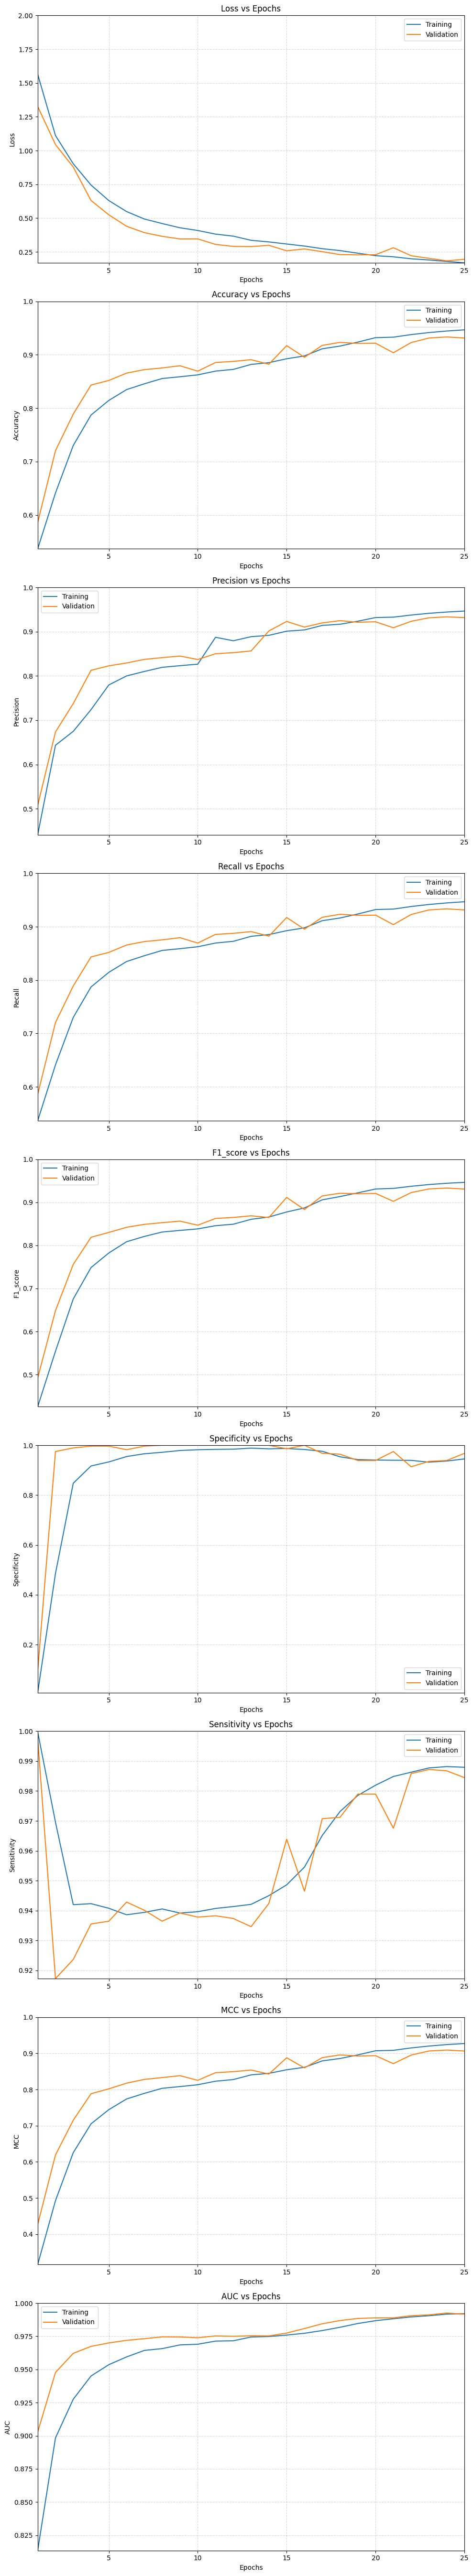

In [11]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])
    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    rng = range(1, num_epochs + 1)
    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]
        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")
        label = metric_name.upper() if metric_name in ("auc", "mcc") else metric_name.capitalize()
        ax.set_ylabel(label)
        ax.set_title(f"{label} vs Epochs")
        max_m = max(max(train_metric), max(val_metric))
        min_m = min(min(train_metric), min(val_metric))
        ax.set_ylim(min_m if min_m < 0 or max_m > 1 else min_m, math.ceil(max_m))
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)
    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

## Test Evaluation

In [12]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, targets in tqdm(test_loader, desc="Testing Model"):
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)
average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
print("Test Metrics:")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")

Testing Model: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]

Test Metrics:
  loss: 0.1886
  accuracy: 0.9302
  precision: 0.9300
  recall: 0.9302
  f1_score: 0.9299
  specificity: 0.9712
  sensitivity: 0.9899
  mcc: 0.9046
  auc: 0.9923


## Classification Report & Confusion Matrix

                     precision    recall  f1-score   support

Bacterial Pneumonia     0.9247    0.9712    0.9474       278
              COVID     0.9724    0.9724    0.9724       362
       Lung_Opacity     0.9154    0.8819    0.8983       601
             Normal     0.9286    0.9441    0.9363      1019
       Tuberculosis     0.9706    0.9429    0.9565        70
    Viral Pneumonia     0.8828    0.8370    0.8593       135

           accuracy                         0.9302      2465
          macro avg     0.9324    0.9249    0.9284      2465
       weighted avg     0.9300    0.9302    0.9299      2465

There were 172 errors in 2465 tests for an accuracy of  93.02%


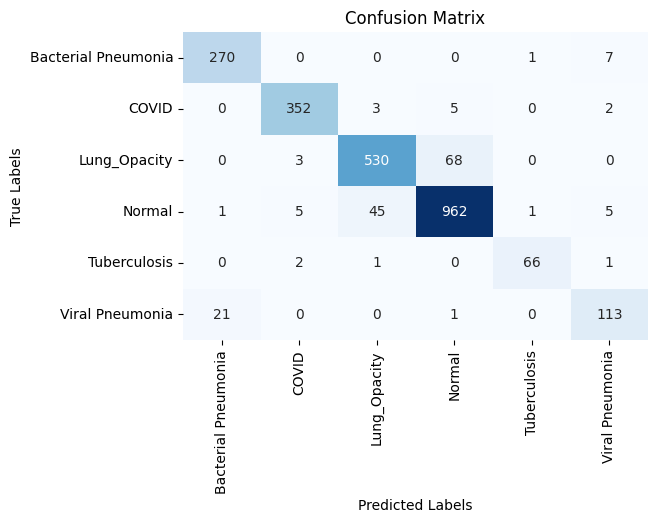

In [13]:
true_labels = np.array(all_targets).astype(int)
predicted_labels = np.argmax(np.array(all_predictions), axis=1).astype(int)
report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)
print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}%')

conf_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    conf_matrix[t, p] += 1
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()